<div align="center">
  <img src="http://gi-mosm.dem.isel.pt/compdrill/img/logo_isel.png"/>
</div>

<h1 align="center"> Instituto Superior de Engenharia de Lisboa </h1>
<h2 align="center"> Licenciatura em Engenharia Informática e Multimédia </h2>
<h3 align="center"> Semestre de Inverno 2020/2021 </h3>

<br></br>
<h3 align="center"> Trabalho Prático Nº 1 </h3>
<br></br>
<h2 align="center"> Processamento de Imagem e Visão </h2>
<h4 align="center"> Docente: Prof. Pedro Jorge </h4>
<br></br>
<h3 align="center"> Grupo 26 </h3>
<br></br>

<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 30%;
  
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

</style>

<table align="center">
  <tr>
    <th>Nome</th>
    <th>Número</th>
    <th>Turma</th>
  <tr>
    <td>Maria Franco</td>
    <td>46320</td>
    <td>51D</td>
  </tr>
  <tr>
    <td>José Siopa</td>
    <td>46338</td>
    <td>51D</td>
  </tr>
</table>

<br></br>
<br></br>
<br></br>

<a name='indice'></a>
# Índice

[](#indice)
- [1. Introdução](#introducao)
- [2. Objetivos](#objetivos)
- [3. Desenvolvimento](#desenvolvimento)
  - [3.1. Binarização](#binarizacao) 
  - [3.2. Operadores Morfológicos](#morfologia)
  - [3.3. Extração de Caraterísticas](#carateristicas)
  - [3.4. Classificação](#classificacao)
- [4. Resultados Experimentais](#resultados)
- [5. Conclusões](#conclusoes)

<a name="introducao"></a> 
# 1. Introdução

Após adquirirmos conhecimentos teóricos acerca de fundamentos de imagens digitais, análise de imagens binárias e conceitos de reconhecimento de padrões, foi-nos proposta a realização deste primeiro trabalho prático. 

De forma a obtermos competências práticas acerca das matérias lecionadas, com recurso à linguagem de programação _Python_ e às bibliotecas _OpenCV_, _Scikit-learn_, _Numpy_ e _Matplotlib_, neste trabalho iremos desenvolver um algoritmo que detete, em imagens, as moedas presentes, e calcule a quantia de dinheiro, em Euros, presente nas mesmas.

<a name="objetivos"></a> 
# 2. Objetivos

Os objetivos da realização deste trabalho prático são:
- Desenvolvimento de algoritmo de visão por computador, capaz de contar automaticamente a quantia
em dinheiro (moedas), colocado em cima de uma mesa;

- Familiarização com a biblioteca de funções _OpenCV (Open Source Computer Vision)_ para
programação de aplicações de visão por computador em tempo real (para linguagem de programação _Python_).

<a name="desenvolvimento"></a> 
# 3. Desenvolvimento

Carregamento das bibliotecas, das imagens de treino e criação duma função para a visualização das imagens através de *plots*.

In [2]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

img_path = glob.glob("imagens_treino/*.jpg")
img_path.sort()

imgs_read = [cv2.imread(img) for img in img_path]

In [3]:
def plot_imgs(n_rows, n_cols, arr_imgs):
    plt.figure(figsize=(15, 10))

    for i in range (len(arr_imgs)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(arr_imgs[i][1], cmap='gray')
        plt.title(arr_imgs[i][0])
        plt.axis('off')

    plt.show()

<a name="binarizacao"></a> 
## 3.1. Binarização

Para corretamente procedermos ao processo de binarização, começámos por separar uma das componentes de cor. Dado que o fundo de todas as imagens é um pano azul, para melhor destacarmos os objetos que estão sobre o mesmo, filtrámos os planos de cor das imagens, de forma a obtermos apenas a componente vermelha. Como se verifica nas imagens abaixo, é a que melhor separa os objetos do fundo. 

Pela análise do histograma da imagem com todos os planos de cor, é possível verificar que a maior quantidade de pixeis, correspondente ao fundo, que é o que ocupa maior área da imagem, se insere nos planos de cor azul e verde. Tal confirma que, para o removermos, tivemos que descartar esses planos de cor, ficando apenas a componente vermelha.

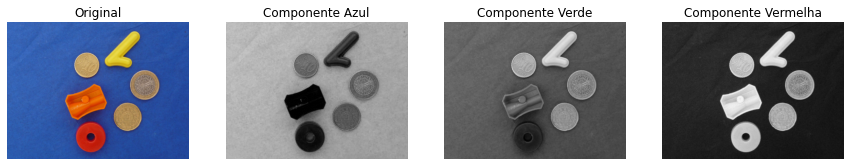

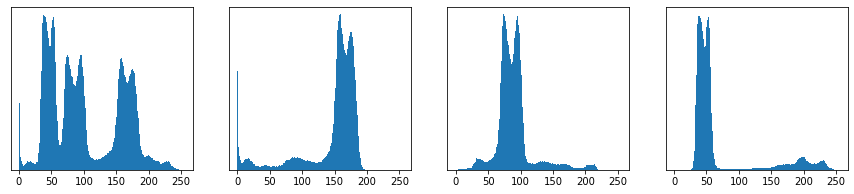

In [4]:
original = cv2.cvtColor(imgs_read[7], cv2.COLOR_BGR2RGB)
img_blue = imgs_read[7][:, :, 0]
img_green = imgs_read[7][:, :, 1]
img_red = imgs_read[7][:, :, 2]

# Aplicar o melhor resultado a todas as imagens
imgs_red = [imgs_read[i][:, :, 2] for i in range(len(imgs_read))]

# Plots
imgs = [['Original', original], ['Componente Azul', img_blue], ['Componente Verde', img_green], ['Componente Vermelha', img_red]]
plot_imgs(1, 4, imgs)

# Histogramas
plt.figure(figsize=(15,3))
plt.subplot(141)
plt.hist(imgs_read[7].ravel(), 256, [0, 255])
ax = plt.gca(); ax.axes.yaxis.set_visible(False)
plt.subplot(142)
plt.hist(imgs_read[7][:,:,0].ravel(), 256, [0, 255])
ax = plt.gca(); ax.axes.yaxis.set_visible(False)
plt.subplot(143)
plt.hist(imgs_read[7][:,:,1].ravel(), 256, [0, 255])
ax = plt.gca(); ax.axes.yaxis.set_visible(False)
plt.subplot(144)
plt.hist(imgs_read[7][:,:,2].ravel(), 256, [0, 255])
ax = plt.gca(); ax.axes.yaxis.set_visible(False)
plt.show()

### Blur

Para facilitar a deteção dos contornos das moedas, teve-se de eliminar as sombras dos objetos nas imagens, bem como a remoção de detalhes muito específicos.

Aplicámos assim o _Gaussian Blur_, para desfocar a imagem e suavizar as arestas. Este *blur* irá calcular a média para um pixel, sendo que os seus pixeis vizinhos mais próximos têm uma influência maior que os mais distantes para este cálculo. 

De seguida, utilizou-se o _Median Blur_, para reduzir ainda mais o ruído da imagem. Este *blur*, para um dado pixel, analisa os vizinhos que o rodeiam e irá usar a mediana destes para lhe ser atribuido.

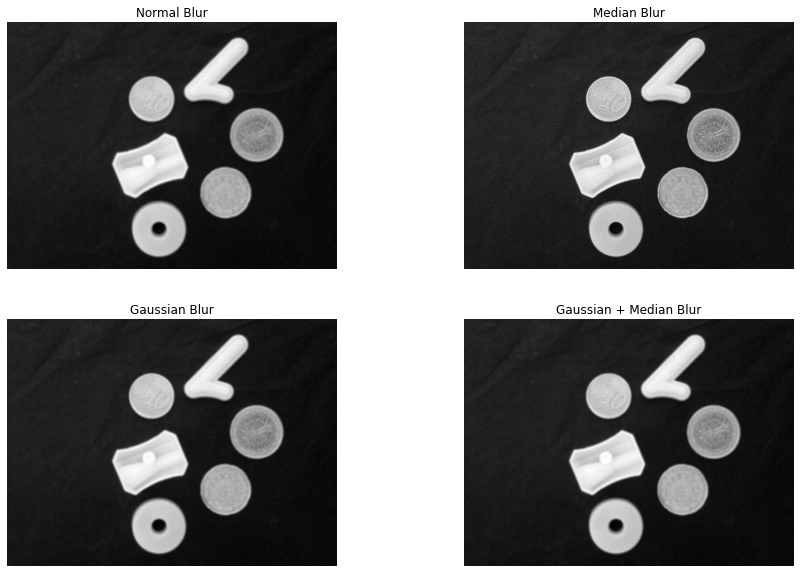

In [5]:
img_blur = cv2.blur(imgs_red[7], (7, 7), 6)
img_median = cv2.medianBlur(imgs_red[7], 3)
img_gaussian = cv2.GaussianBlur(imgs_red[7], (7, 7), 6)
img_med_gaus = cv2.medianBlur(img_gaussian, 3)

# Aplicar a todas as imagens
imgs_blured = []
for i in range(len(imgs_red)):
    img_gaus = cv2.GaussianBlur(imgs_red[i], (7, 7), 6)
    imgs_blured.append(cv2.medianBlur(img_gaus, 3))

# Plots
imgs = [['Normal Blur', img_blur], ['Median Blur', img_median], ['Gaussian Blur', img_gaussian], ['Gaussian + Median Blur', img_med_gaus]]
plot_imgs(2, 2, imgs)

### Threshold

A binarização foi realizada pelo método _threshold_, onde simplesmente esta irá colocar todos os pixeis a 0, se forem menores que o limiar, ou para o valor máximo (neste caso 255) se forem maiores que o limiar.

Determinámos que o limiar de Otsu, que varia o limiar automaticamente, era o mais apropriado pois, pelo histograma da imagem com o plano de cor vermelha escolhido, apresentado abaixo, coloca o limiar de forma a separar o tom do fundo do tom das moedas.

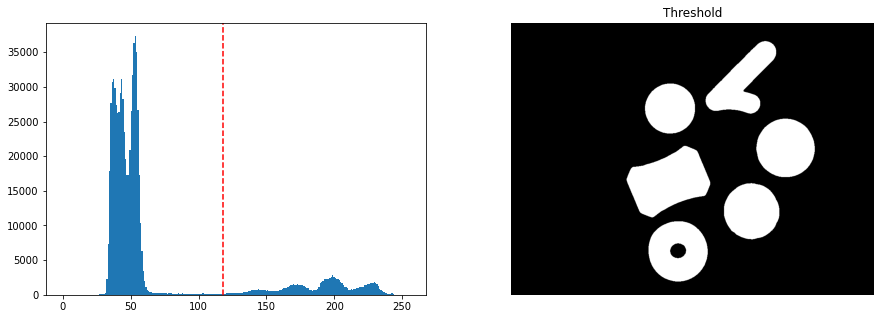

In [6]:
limiar, threshold = cv2.threshold(img_med_gaus, 0, 255, cv2.THRESH_OTSU)

# Aplicar a todas as imagens
imgs_thresh = []
for i in range(len(imgs_blured)):
    thresh = cv2.threshold(imgs_blured[i], 0, 255, cv2.THRESH_OTSU)[1]
    imgs_thresh.append(thresh)
    

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(img_blur.ravel(), 256, [0, 255])
plt.axvline(limiar, color='r', ls='--')

plt.subplot(122)
plt.imshow(threshold, cmap='gray')
plt.title('Threshold')
plt.axis('off')
plt.show()

<a name="morfologia"></a> 
## 3.2. Operadores Morfológicos

Os operadores morfológicos são operações baseadas na forma da imagem, normalmente em imagens binárias. Estes precisam de dois argumentos, a imagem e o elemento estruturante (ou *kernel*) que irá decidir a natureza da operação.

Para aplicar os operadores morfológicos de modo a separar objetos que possam estar a ser interpretados como um só, escolhemos um elemento estruturante com a forma de disco, visto que pretendemos detetar as moedas e estas têm uma forma circular. O formato de disco irá então preservar a curvatura dos contornos. O tamanho 41 foi o que considerámos apropriado de modo a separar moedas que pudessem estar encostadas.

### Erosão e Dilatação

A operação de erosão baseia-se em aplicar o elemento estruturante sobre cada pixel ativo da imagem, mantendo o seu valor a 1 se todos os pixeis sob o elemento estruturante estiverem a 1. Se tal não acontecer, o pixel passa a 0. Isto faz com que os pixeis do rebordo de cada objeto sejam eliminados e a área do objeto diminua.

A operação de dilatação aplica o elemento estruturante da mesma forma mas o pixel ir-se-á manter a 1 caso um ou mais dos pixeis sob o elemento esteja a 1. Apenas ficará a zero se nenhum outro pixel sob o elemento estruturante estiver ativo. Esta operação irá assim aumentar a área dos objetos.

Como o objetivo é separar objetos, a operação que nos irá favorecer é a erosão (_erode_).

Nas imagens abaixo pode-se verificar o efeito produzido  destas duas operações.

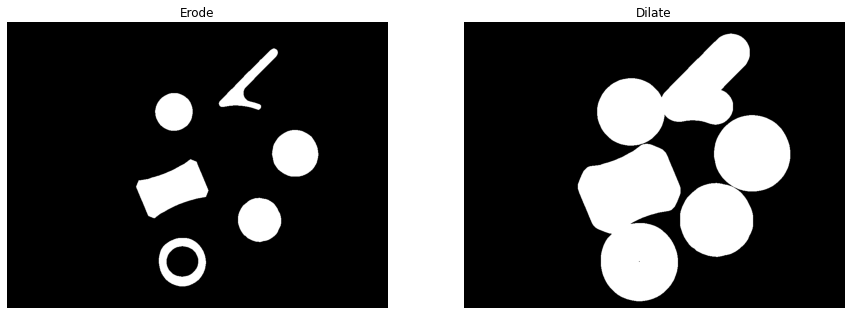

In [7]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (41, 41), (-1, -1))
eroded = cv2.erode(threshold, element)
dilated = cv2.dilate(threshold, element)

# Aplicar a todas as imagens o melhor resultado
imgs_eroded = []
for i in range(len(imgs_thresh)):
    erode = cv2.erode(imgs_thresh[i], element)
    imgs_eroded.append(erode)

# Plot
imgs = [['Erode', eroded], ['Dilate', dilated]]
plot_imgs(1, 2, imgs)

### Fecho e abertura

O fecho trata-se de uma dilatação seguida de uma erosão. Tal como o nome indica, é útil para fechar os contornos, suavizando a sua curvatura, e pequenos espaços que possam existir no interior dos objetos.

A abertura realiza as mesmas operações por ordem inversa, uma erosão seguida de uma dilatação. Mais uma vez, tal como o nome indica, permite abrir os contornos dos objetos e reduzir o ruído.

Para suavizar os contornos dos objetos de forma a facilitar a identificação das formas geométricas bem definidas, aplicámos o operador morfológico de fecho (_close_). 

Como se pode verificar pelas figuras abaixo, ao contrário da abertura (_open_), que elimina a forma de alguns objetos, o fecho providenciou os resultados pretendidos.

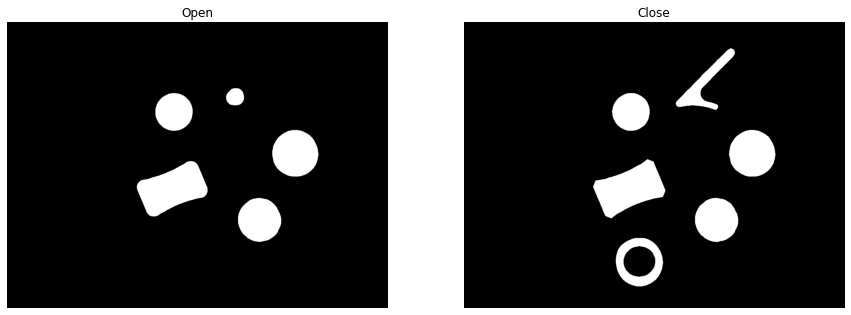

In [8]:
opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, element)
closed = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, element)

# Aplicar a todas as imagens o melhor resultado
imgs_closed = []
for i in range(len(imgs_eroded)):
    close = cv2.morphologyEx(imgs_eroded[i], cv2.MORPH_CLOSE, element)
    imgs_closed.append(close)

# Plot
imgs = [['Open', opened], ['Close', closed]]
plot_imgs(1, 2, imgs)

<a name="carateristicas"></a> 
## 3.3. Extração de Caraterísticas

Para delinear os contornos dos objetos após a aplicação dos operadores morfológicos, usámos a função _findContours_, em modo de árvore. Esta retorna todos os contornos existentes numa imagem, bem como propriedades de cada um dos contornos. Uma destas propriedades incluí o número de contornos filhos, que será importante para a classificação das moedas.

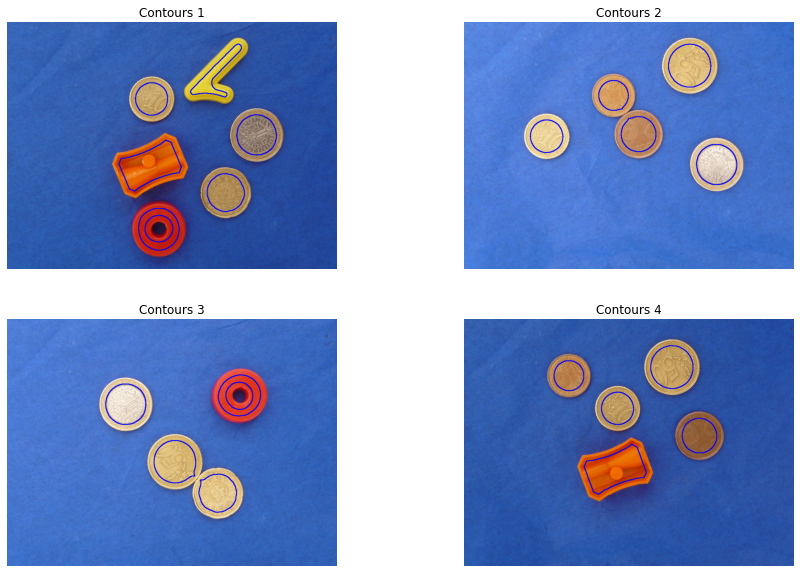

In [9]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgs_read[7], contours, -1, (255, 0, 0), 2)

# Aplicar a todas as imagens
imgs_contours = []
for i in range(len(imgs_closed)):
    contour, hier = cv2.findContours(imgs_closed[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgs_read[i], contour, -1, (255, 0, 0), 2)
    imgs_contours.append((cv2.cvtColor(imgs_read[i], cv2.COLOR_BGR2RGB), contour, hier))

# Plot
imgs = [['Contours 1', imgs_contours[7][0]], ['Contours 2', imgs_contours[5][0]], 
        ['Contours 3', imgs_contours[8][0]], ['Contours 4', imgs_contours[3][0]]]
plot_imgs(2, 2, imgs)

<a name="classificacao"></a> 
## 3.4. Classificação

Para a classificação das moedas, verificámos se a área e o perímetro dos objetos se encontrava num dado intervalo, analisando a sua circularidade. Também procurámos pela inexistência de buracos nos objetos, pela ausência de componentes filhos na hierarquia dos contornos. Desta forma, criámos um classificador do tipo árvore de decisão que separa os objetos diversos das moedas, através dos parâmetros mencionados anteriormente.

Para distinguir o valor dos objetos classificados como moedas, criámos regiões de decisão. Estas baseiam-se nos valores obtidos para as áreas das imagens de teste (estes valores estão presentes na Tabela abaixo), deixando um intervalo de erro para valores que possam estar mais dispersos do que os das imagens de teste.

Depois de feitas as regiões de decisão através das áreas, reparámos que ainda houveram objetos que estavam a ser mal classificados, pelo que tivemos de recorrer a uma nova região de decisão, o perímetro. Para este intervalo, apenas foi necessário calcular o perímetro mínimo e máximo de uma moeda.

Sabendo os valores aproximados para cada uma das moedas e com base em medições reais, podemos especular qual será o intervalo para as moedas de 2 euros.

A especulação para a imagem de 2 euros foi feita pela estimação de um intervalo de valores que caracterizam a região de decisão da classe, superiores aos da de 50 cêntimos e aos das restantes.

--        | 1 cêntimo   | 2 cêntimos  | 5 cêntimos | 10 cêntimos | 20 cêntimos | 50 cêntimos | 1 euro
:-------: | :---------: | :---------: | :--------: | :---------: | :---------: | :---------: | :-----:
--        | 4416.5      | 6983.5      | 9337       | 7769        | 11076       | 13527.5     | 12062
--        | 4188        | 6868.5      | 9049       | 7776.5      | 10507.5     | 13731.5     | 12061.5
--        | 4200.5      | 6819        | 9165.5     | 7810.5      | 10787.5     | 13693.5     | 12230.5
--        | --          | 6770.5      | 9212.5     | 7962        | 10791       | 13559       | 12225
--        | --          | 6665        | --         | 7976        | 10605.5     | 13696.5     | 12083.5
--        | --          | 6694.5      | --         | 7815        | 10497.5     | 13487       | 12045
--        | --          | --          | --         | 7877.5      | 10780       | --          | 12341.5
Média     | 4268.3      | 6800.1      | 9191.5     | 7855.2      | 10720.7     | 13615.8     | 12149.9
Intervalo | 4000-5000   | 6000-7000   | 8800-9800  | 7200-8200   | 10000-11200 | 13000-14000 | 11700-12800

In [10]:
def classify_coin(contour, hierarchy):

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if 4000 < area < 15200 and 230 < perimeter < 450 and hierarchy[2] == -1 and hierarchy[3] == -1:

        if 13000 < area < 14000:
            return '50cent', 0.50, 5
        elif 11700 < area < 12800:
            return '1euro', 1.0, 6
        elif 10000 < area < 11200:
            return '20cent', 0.20, 4
        elif 8800 < area < 9800:
            return '5cent', 0.05, 2
        elif 7200 < area < 8200:
            return '10cent', 0.10, 3
        elif 6000 < area < 7000:
            return '2cent', 0.02, 1
        elif 4000 < area < 5000:
            return '1cent', 0.01, 0
        else:
            return '2euro', 2.0, 7

    return 'Null', 0

<a name="resultados"></a> 
# 4. Resultados Experimentais

Para demonstrar os resultados, assinalámos nas imagens o valor de cada moeda e, no canto superior esquerdo, a quantia contada nas moedas presentes em cada imagem.

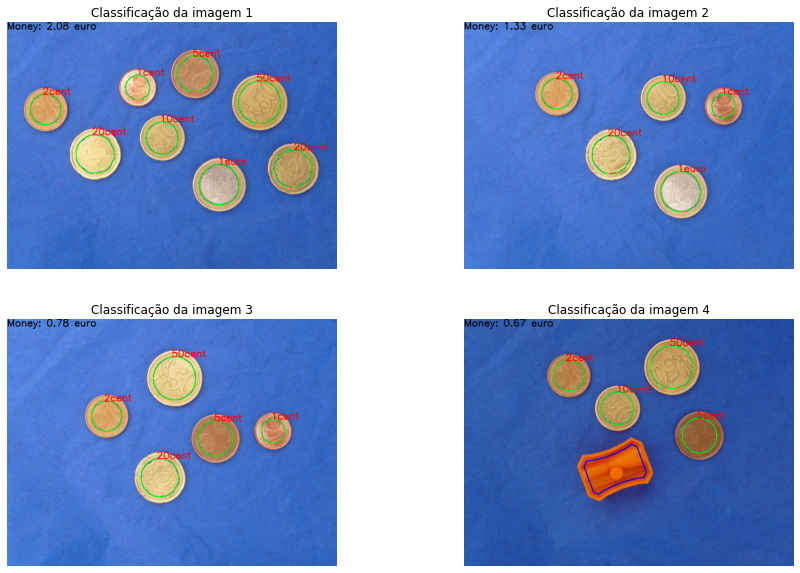

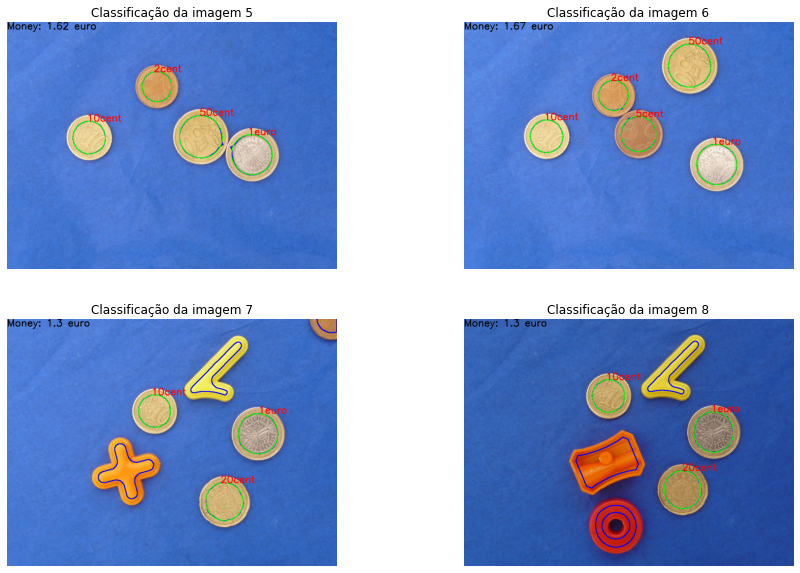

In [11]:
# Percorrer todas as imagens
predicted_class = []
for i in range(len(imgs_contours)):
    total_money = 0

    # Percorrer todos os contornos de uma imagem
    for j in range(len(imgs_contours[i][1])):
        contour = imgs_contours[i][1][j]
        hierarchy = imgs_contours[i][2][0][j]

        coin_type = classify_coin(contour, hierarchy)

        if coin_type[0] != 'Null': 
            total_money += coin_type[1]
            predicted_class.append(coin_type[2])
            
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(imgs_contours[i][0], ellipse, color=(0, 255, 0), thickness=2)
            cv2.putText(imgs_contours[i][0], coin_type[0], (contour[0][0][0], contour[0][0][1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.putText(imgs_contours[i][0], 'Money: ' + str(np.round(total_money, 2)) + ' euro', (0, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Plots
final_imgs = [['Classificação da imagem 1', imgs_contours[0][0]], ['Classificação da imagem 2', imgs_contours[1][0]],
              ['Classificação da imagem 3', imgs_contours[2][0]], ['Classificação da imagem 4', imgs_contours[3][0]]]

final_imgs2 = [['Classificação da imagem 5', imgs_contours[4][0]], ['Classificação da imagem 6', imgs_contours[5][0]],
               ['Classificação da imagem 7', imgs_contours[6][0]], ['Classificação da imagem 8', imgs_contours[7][0]]]

plot_imgs(2, 2, final_imgs)
plot_imgs(2, 2, final_imgs2)

Para avaliar o classificador utilizado, gerou-se uma matriz de confusão, que relaciona as classes originais com as estimadas pelo mesmo. Na diagonal da matriz, encontra-se a quantidade de acertos por cada classe e, fora da diagonal, os erros cometidos. 

Calculou-se, também, a probabilidade de erro, que é o número de amostras mal classificadas a dividir pela quantidade de amostras. 

À classe 0 pertencem as moedas de 1 cêntimo, e aumenta de forma crescente de valor monetário, até à moeda de 2 euros, da classe 7. Esta última não se encontra representada na matriz de confusão por não termos nenhuma amostra nas imagens de treino.

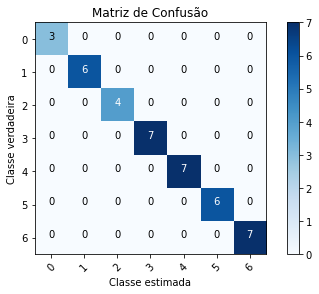

In [12]:
from sklearn.metrics import confusion_matrix
from libs.plot_confusion_matrix import plot_confusion_matrix

real_class = np.array([6, 4, 4, 3, 1, 5, 0, 2, 6, 4, 0, 3, 1, 4, 2, 0, 1, 5, 2, 3, 1, 5, 6, 3, 5, 1, 6, 3, 2, 1, 5, 4, 6, 3, 4, 6, 3, 4, 5, 6])

MC = confusion_matrix(real_class, predicted_class)
plot_confusion_matrix(MC)

In [13]:
print("Probabilidade de erro =", np.sum(real_class!=predicted_class) / len(predicted_class), "%")

Probabilidade de erro = 0.0 %


Dado que foi obtida uma probabilidade de erro nula neste classificador, com o conjunto de imagens de treino, pode-se concluir que obtivemos um classificador ótimo.

<a name="conclusoes"></a> 
# 5. Conclusões

Com este trabalho, pudemos observar que são necessárias várias operações sobre cada imagem para que nelas se possa aplicar um  classificador e obter uma classificação com o mínimo de erros.

Com a ajuda da biblioteca do _OpenCV_, colocámos em prática os conhecimentos obtidos em aulas teóricas e teórico-práticas.

Assim, com as imagens de treino que possuíamos, todos os objetos que continham foram corretamente classificados.